<a href="https://colab.research.google.com/github/sbksum/RAG/blob/main/HelpMateAI_Generative_Search_Shashi_khurana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. <font color = red> Install and Import the Required Libraries

In [ ]:
# Install all the required libraries

!pip install -U -q pdfplumber tiktoken openai chromaDB sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [ ]:
# Define the path of the PDF
#single_pdf_path = '/content/drive/MyDrive/GenAI - Personal/HelpMate AI Codes/Week 3/Policy Documents/HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf'
single_pdf_path = "/content/drive/My Drive/HelpMateAI/Principal-Sample-Life-Insurance-Policy.pdf"

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [ ]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

Section A – Eligibility
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section B - Effective Dates
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section C - Individual Terminations
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Termination for Fraud Article 4
Coverage While Outside of the United States Article 5
Section D - Continuation
Member Life Insurance Article 1
Dependent Insurance - Developmentally Disabled or
Physically Handicapped Children Article 2
Section E - Reinstatement
Reinstatement Article 1
Federal Required Family and Medical Leave Act (FMLA) Article 2
Reinstatement of Coverage for a Member or Dependent When
Coverage Ends due to Living Outside of the United States Article 3
Section F - Individual Purchase Rights
Member Life In

In [ ]:
 #Define the path and place the document to that folder, it gives opportunity to place multiple documents here as well

# pdf_path = "/content/drive/My Drive/HelpMate AI Codes/Policy Documents"
pdf_path = "/content/drive/My Drive/HelpMateAI/PolicyDocuments"

In [ ]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [ ]:
def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [ ]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [ ]:
print(data)

[   Page No.                                          Page_Text  \
0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
1    Page 2                 This page left blank intentionally   
2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
3    Page 4                 This page left blank intentionally   
4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   
..      ...                                                ...   
59  Page 60  I f a Dependent who was insured dies during th...   
60  Page 61  Section D - Claim Procedures Article 1 - Notic...   
61  Page 62  A claimant may request an appeal of a claim de...   
62  Page 63                 This page left blank intentionally   
63  Page 64  Principal Life Insurance Company Des Moines, I...   

                                 Document Name  
0   Principal-Sample-Life-Insurance-Policy.pdf  
1   Principal-Sample-Life-Insurance-Policy.pdf  
2   Principal-Sample-Life-Insurance-Policy.pdf  
3   Princi

In [ ]:
insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [ ]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy.pdf
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf
61,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy.pdf
62,Page 63,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf


In [ ]:
insurance_pdfs_data.Page_Text[2]

'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the

In [ ]:
insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [ ]:
insurance_pdfs_data['Text_Length']

0      30
1       5
2     230
3       5
4     110
     ... 
59    285
60    418
61    322
62      5
63      8
Name: Text_Length, Length: 64, dtype: int64

In [ ]:
# Retain only the rows with a text length of at least 10
insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352


In [ ]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

<ipython-input-56-4493f15e2dc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [ ]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171,{'Policy_Name': 'Principal-Sample-Life-Insuran...
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387,{'Policy_Name': 'Principal-Sample-Life-Insuran...
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251,{'Policy_Name': 'Principal-Sample-Life-Insuran...
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299,{'Policy_Name': 'Principal-Sample-Life-Insuran...
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352,{'Policy_Name': 'Principal-Sample-Life-Insuran...


## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [ ]:
# Set the API key
filepath = "/content/drive/My Drive/HelpMateAI/"

with open(filepath + "api_key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [ ]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [ ]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/My Drive/HelpMateAI/ChromaDB_Data'

In [ ]:
import chromadb

In [ ]:
 #Call PersistentClient()

client = chromadb.PersistentClient()

In [ ]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [ ]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

In [ ]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [ ]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [ ]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.022469419986009598,
   0.01871146820485592,
   -0.02729734405875206,
   -0.031290166079998016,
   -0.0036731369327753782,
   0.027923669666051865,
   0.0008538575493730605,
   0.023656828328967094,
   -0.016571523621678352,
   0.004253792576491833,
   -0.005251998547464609,
   0.004058065824210644,
   -0.006273039150983095,
   0.023252326995134354,
   -0.011299951933324337,
   0.030977005138993263,
   0.002877181861549616,
   -0.024726800620555878,
   0.03055945597589016,
   0.007920404896140099,
   0.006413309834897518,
   0.01886804960668087,
   0.00953188817948103,
   0.012689611874520779,
   -0.012356876395642757,
   -0.009440548717975616,
   0.017889415845274925,
   -0.021686512976884842,
   0.023526344448328018,
   0.0030223457142710686,
   0.013283316045999527,
   -0.0145490150898695,
   -0.03361279144883156,
   -0.041180890053510666,
   -0.00845539104193449,
   0.013531235978007317,
   -0.0026716687716543674,
   -0.003868863452225923

In [ ]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [ ]:
cache_collection.peek()

{'ids': [],
 'embeddings': [],
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None,
 'included': ['embeddings', 'metadatas', 'documents']}

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [ ]:
# Read the user query

query = input()

What is policyholder eligibility requirements?


In [ ]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [ ]:
cache_results

{'ids': [[]],
 'distances': [[]],
 'metadatas': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

In [ ]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)
results.items()

dict_items([('ids', [['14', '3', '10', '23', '13', '15', '21', '39', '1', '19']]), ('distances', [[0.2698811135675829, 0.32155733922828894, 0.32157411625062016, 0.32490730848714544, 0.32749878219187284, 0.3327528570740543, 0.33338120959196016, 0.34728344225041147, 0.35323862398613526, 0.3567445278041331]]), ('metadatas', [[{'Page_No.': 'Page 17', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 6', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 13', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 26', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 16', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 18', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 24', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 42', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 3

In [ ]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.4

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=3
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        for i in range(3):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [ ]:
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,0.269881,14
1,"{'Page_No.': 'Page 6', 'Policy_Name': 'Princip...",TABLE OF CONTENTS PART I - DEFINITIONS PART II...,0.321557,3
2,"{'Page_No.': 'Page 13', 'Policy_Name': 'Princi...",a . A licensed Doctor of Medicine (M.D.) or Os...,0.321574,10


## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

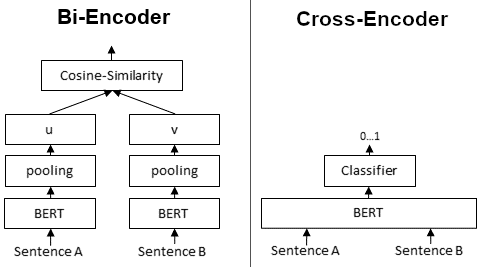

<br>

In [ ]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Test the cross encoder model

scores = cross_encoder.predict([['what are eligibility requirements?', 'To be an eligible group and to remain an eligible group, the Policyholder must:'],
                                ['what are eligibility requirements?', 'make at least the level of premium contributions required for insurance on its eligible Members.']])

In [ ]:
scores

array([-0.7566209, -3.0189762], dtype=float32)

In [ ]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [ ]:
cross_rerank_scores

array([ 1.4343287,  2.1128156, -1.7013217], dtype=float32)

In [ ]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [ ]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,0.269881,14,1.434329
1,"{'Page_No.': 'Page 6', 'Policy_Name': 'Princip...",TABLE OF CONTENTS PART I - DEFINITIONS PART II...,0.321557,3,2.112816
2,"{'Page_No.': 'Page 13', 'Policy_Name': 'Princi...",a . A licensed Doctor of Medicine (M.D.) or Os...,0.321574,10,-1.701322


In [ ]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,0.269881,14,1.434329
1,"{'Page_No.': 'Page 6', 'Policy_Name': 'Princip...",TABLE OF CONTENTS PART I - DEFINITIONS PART II...,0.321557,3,2.112816
2,"{'Page_No.': 'Page 13', 'Policy_Name': 'Princi...",a . A licensed Doctor of Medicine (M.D.) or Os...,0.321574,10,-1.701322


In [ ]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
1,"{'Page_No.': 'Page 6', 'Policy_Name': 'Princip...",TABLE OF CONTENTS PART I - DEFINITIONS PART II...,0.321557,3,2.112816
0,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,0.269881,14,1.434329
2,"{'Page_No.': 'Page 13', 'Policy_Name': 'Princi...",a . A licensed Doctor of Medicine (M.D.) or Os...,0.321574,10,-1.701322


In [ ]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [ ]:
top_3_RAG

,Documents,Metadatas
1,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,"{'Page_No.': 'Page 6', 'Policy_Name': 'Princip..."
0,a. be actively engaged in business for profit ...,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi..."
2,a . A licensed Doctor of Medicine (M.D.) or Os...,"{'Page_No.': 'Page 13', 'Policy_Name': 'Princi..."


## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [ ]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [ ]:
# Generate the response

response = generate_response(query, top_3_RAG)

In [ ]:
# Print the response

print("\n".join(response))

The policyholder eligibility requirements typically include being actively engaged in business for profit or being a licensed Doctor of Medicine (M.D.) or Doctor of Osteopathy (D.O.). These criteria may vary based on the specific policy document and insurance provider.

As per the documents provided:
- Policy Name: Principal Policy
- Page Number: Page 17

Please refer to the Principal Policy document on Page 17 for more detailed information on policyholder eligibility requirements.

---

**Citations:**
- Policy Name: Principal Policy
- Page Number: Page 17
